In [1]:
#import psycopg
import pandas as pd
from typing import List,Tuple,Dict
import re
from pathlib import Path

In [103]:
timings = list(x.read_text() for x in Path("/home/jovyan/creation/").glob("timings_*.txt"))
timings

["timing on\nCOPY customer\nFROM '/etc/data/customer.tbl' WITH DELIMITER AS '|';\nTime: 20738.715 ms (00:20.739)\nCOPY lineitem\nFROM '/etc/data/lineitem.tbl' WITH DELIMITER AS '|';\nTime: 897060.608 ms (14:57.061)\nCOPY nation\nFROM '/etc/data/nation.tbl' WITH DELIMITER AS '|';\nTime: 5.160 ms\nCOPY orders\nFROM '/etc/data/orders.tbl' WITH DELIMITER AS '|';\nTime: 184302.848 ms (03:04.303)\nCOPY part\nFROM '/etc/data/part.tbl' WITH DELIMITER AS '|';\nTime: 28187.445 ms (00:28.187)\nCOPY partsupp\nFROM '/etc/data/partsupp.tbl' WITH DELIMITER AS '|';\nTime: 110522.000 ms (01:50.522)\nCOPY region\nFROM '/etc/data/region.tbl' WITH DELIMITER AS '|';\nTime: 3.748 ms\nCOPY supplier\nFROM '/etc/data/supplier.tbl' WITH DELIMITER AS '|';\nTime: 1064.242 ms (00:01.064)\nALTER TABLE REGION\nADD PRIMARY KEY (R_REGIONKEY);\nTime: 13.820 ms\nALTER TABLE NATION\nADD PRIMARY KEY (N_NATIONKEY);\nTime: 3.209 ms\nALTER TABLE CUSTOMER\nADD PRIMARY KEY (C_CUSTKEY);\nTime: 6462.514 ms (00:06.463)\nALTER TAB

In [138]:
def extract_all_info(payload : str):
    load_speeds_table = re.findall("COPY (\w+)",payload)
    pk_speeds_table = list(map(str.lower,re.findall("ALTER TABLE ([A-Z]+)\nADD PRIMARY[^;]+",payload,re.MULTILINE)))
    fk_speeds_table = re.findall("ALTER TABLE ([A-Z]+)\nADD FOREIGN KEY \(([^\)]+)",payload,re.MULTILINE)
    time = list(map(lambda x:float(x)/1000,re.findall("Time: (\d+\.\d+) ms",payload)))

    copy_speeds = zip(load_speeds_table,time)
    time = time[len(load_speeds_table):]

    pk_speeds = zip(pk_speeds_table,time)
    time = time[len(pk_speeds_table):]

    splitted = list(zip(*fk_speeds_table))
    fk_speeds = zip(map(str.lower,splitted[0]),map(str.lower,splitted[1]),time)

    return copy_speeds,pk_speeds,fk_speeds


copy_speeds,pk_speeds,fk_speeds = list(map(list,extract_all_info(timings[0])))
copy_speeds,pk_speeds,fk_speeds

([('customer', 20.738715),
  ('lineitem', 897.060608),
  ('nation', 0.0051600000000000005),
  ('orders', 184.302848),
  ('part', 28.187445),
  ('partsupp', 110.522),
  ('region', 0.003748),
  ('supplier', 1.064242)],
 [('region', 0.01382),
  ('nation', 0.003209),
  ('customer', 6.4625140000000005),
  ('supplier', 0.17447300000000002),
  ('part', 12.220457),
  ('partsupp', 55.008331),
  ('orders', 81.74841400000001),
  ('lineitem', 393.032202)],
 [('nation', 'n_regionkey', 0.027391),
  ('supplier', 's_nationkey', 0.331431),
  ('customer', 'c_nationkey', 3.717676),
  ('partsupp', 'ps_suppkey', 25.833757000000002),
  ('partsupp', 'ps_partkey', 32.606522),
  ('orders', 'o_custkey', 66.526355),
  ('lineitem', 'l_orderkey', 239.83935300000002),
  ('lineitem', 'l_partkey, l_suppkey', 303.768421)])

In [139]:
copy_speeds,pk_speeds,fk_speeds = list(),list(),list()

for payload in timings:
    a,b,c = extract_all_info(payload)
    copy_speeds += (a)
    pk_speeds += (b)
    fk_speeds += (c)

In [140]:
df_loading_speeds =  pd.DataFrame(copy_speeds, columns=['Table', 'Time'])
df_loading_speeds["Size (MB)"] = df_loading_speeds["Table"].map(
    lambda x: Path(f"/home/jovyan/work/data-management/data/{x}.tbl").stat().st_size / 2**20
)
df_loading_speeds["Throughput (MB/s)"] = (df_loading_speeds["Size (MB)"] / df_loading_speeds["Time"])
print(df_loading_speeds.sort_values("Table")[["Table","Time"]].to_csv(path_or_buf=open("loading_speed.csv","w"),index=False))

None


<Axes: title={'center': 'Time to load each table'}, xlabel='Table', ylabel='Time in seconds'>

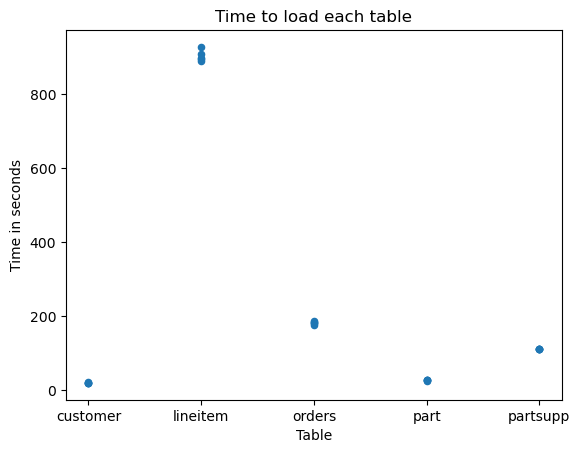

In [141]:
df_loading_speeds.query("`Size (MB)` > 1024").plot(
    kind="scatter",title="Time to load each table",x="Table",y="Time",ylabel="Time in seconds"
)

<Axes: title={'center': 'Time to create the primary key for each table bigger than 5GB'}, xlabel='Table', ylabel='Time in seconds'>

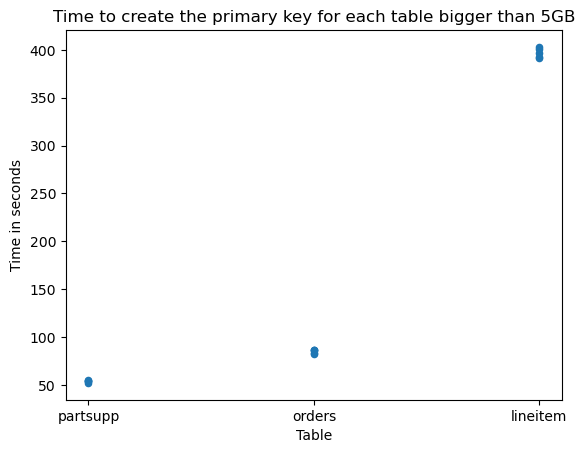

In [142]:
df_pk_speed = pd.DataFrame(pk_speeds,columns="Table Time".split(" "))
df_pk_selected = df_pk_speed.merge(
    right=df_loading_speeds.query(f"`Size (MB)` > 5*1024")["Table"].drop_duplicates(),on="Table",how="inner"
)

df_pk_selected.plot(
    kind="scatter",title="Time to create the primary key for each table bigger than 5GB",x="Table",y="Time",ylabel="Time in seconds"
)

In [143]:
print(df_pk_selected.sort_values("Table")[["Table","Time"]].to_csv(path_or_buf=open("pk_creation.csv","w"),index=False))

None


<Axes: title={'center': 'Time to create the foreign key for each table bigger than 5GB'}, xlabel='Table', ylabel='Time in seconds'>

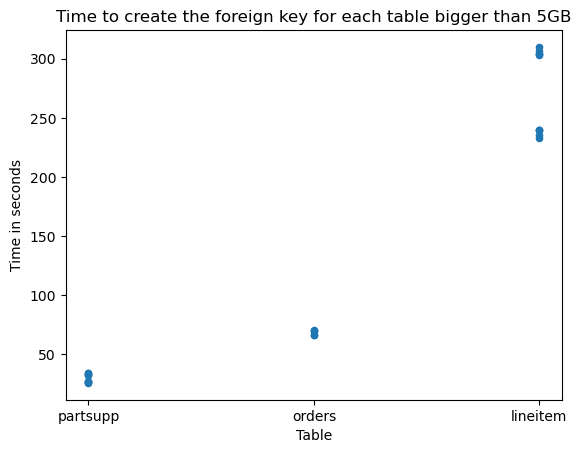

In [144]:
df_fk_speed = pd.DataFrame(fk_speeds,columns="Table Key Time".split(" "))
df_fk_selected = df_fk_speed.merge(
    right=df_loading_speeds.query(f"`Size (MB)` > 5*1024")["Table"].drop_duplicates(),on="Table",how="inner"
)

df_fk_selected.plot(
    kind="scatter",title="Time to create the foreign key for each table bigger than 5GB",x="Table",y="Time",ylabel="Time in seconds"
)

In [145]:
df_fk_selected.sort_values("Table")[["Key","Time"]].to_csv(path_or_buf=open("fk_creation.csv","w"),index=False)

In [146]:
stats = df_loading_speeds.groupby("Table")["Throughput (MB/s)"].describe().sort_values("mean",ascending=False)[["mean","std","min","max"]]
print(stats.to_csv(path_or_buf=open("throughput.csv","w")))

None


In [147]:
stats = df_loading_speeds.groupby("Table")["Time"].describe().sort_values("mean",ascending=False)[["mean","std","min","max"]]
print(stats.to_csv(path_or_buf=open("table_creation.csv","w")))

None


In [148]:
timings = list(Path("/home/jovyan/query-results/").glob("*.txt"))

# import re

# def natural_sort(l): 
#     convert = lambda text:  if text.isdigit() else text.lower()
#     alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key.stem)]
#     return sorted(l, key=alphanum_key)

# timings = natural_sort(timings)
timings = list((x.stem,x.read_text()) for x in timings)

In [149]:
import collections
query_times = collections.defaultdict(list)

In [150]:
for name,text in reversed(timings):
    time = re.search("Time: (\d+\.\d+) ms",text).group(1)
    sample = re.search("timings-query_\d+-(\d+)",name).group(1)
    query_times[str(sample)].append(float(time)/1000)

In [157]:
df_queries = pd.DataFrame.from_dict(query_times).describe().transpose()[["mean","std","min","max"]].sort_values("mean",ascending=False)
df_queries.sort_index().to_csv(path_or_buf=open("queries.csv","w"))

# Paralell queries

In [2]:
timings = list(Path("/home/jovyan/concurrent/").glob("*.txt"))
timings = list((x.stem,x.read_text()) for x in timings)

In [3]:
import collections
query_times = collections.defaultdict(list)

for name,text in reversed(timings):
    time = re.search("Time: (\d+\.\d+) ms",text).group(1)
    sample = re.search("timings-query_\d+-(\d+)",name).group(1)
    query_times[str(sample)].append(float(time)/1000)

In [10]:
df_queries = pd.DataFrame.from_dict(query_times)
df_queries.sort_index().to_csv(path_or_buf=open("concurrent.csv","w"))